In [1]:
import numpy as np
from scipy import linalg
from qutip import *
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def zero_constrain(tlist,T,y):
    return np.sin(tlist/T *np.pi)*y

In [3]:
def optimize_pulse_test(pulse_init, tlist, itr, Nc, L_rate, U_target):
    
    dt = tlist[1]-tlist[0]

    @tf.function
    def expm(h_k):
        return tf.linalg.expm(-1j * dt * h_k)
    
    u1 = tf.Variable(pulse_init, name='u1', dtype=tf.float32)

    optimizer = tf.keras.optimizers.Adam(learning_rate = L_rate)
    U_ideal = tf.constant(np.array(U_target), dtype=tf.complex128)

    indices = tf.reshape(tf.range(Nc+1,u1.shape[0]-Nc),shape=[u1.shape[0]-2*Nc-1,1])
    count = 0
    C_list = []  #  cost function
    F_list = []  #  fidelity
    for _ in tf.range(itr):
        with tf.GradientTape() as tape:
            u_complex1 = tf.cast(u1, tf.complex128)
            tlist = tf.cast(tlist, tf.complex128)
            
            fft_seq1 = tf.signal.fft(u_complex1)
            fft_filtered1 = fft_seq1-tf.scatter_nd(indices, fft_seq1[Nc+1:-Nc], u1.shape) # filter
            u_complex1 = tf.signal.ifft(fft_filtered1) # inverse Fourier transform
            
            u_complex1 = tf.cast(zero_constrain(tlist, T, u_complex1),tf.complex128)

            u_in = tf.cast(u_complex1,tf.complex128)
            
            sigmx = tf.cast(sigmax(),tf.complex128)
            sigmy = tf.cast(sigmay(),tf.complex128)
            sigmz = tf.cast(sigmaz(),tf.complex128)

            hd = []
            for i in range(len(tlist)):
                hd.append(0.5*u_in[i]*sigmx)
            hd = tf.stack(hd)

            xd = []
            yd = []
            zd = []

            U_list = []
            U0 = tf.constant(np.array(identity(2)), dtype=tf.complex128)
            U_list.append(U0)
            for i in tf.range(1,len(tlist)):
                U_step = expm(hd[i]) @ U_list[i-1]
                U_list.append(U_step)
                xd.append( 0.5*tf.linalg.trace(sigmx @ tf.linalg.adjoint(U_step) @ sigmz @ U_step) )
                yd.append( 0.5*tf.linalg.trace(sigmy @ tf.linalg.adjoint(U_step) @ sigmz @ U_step) )
                zd.append( 0.5*tf.linalg.trace(sigmz @ tf.linalg.adjoint(U_step) @ sigmz @ U_step) )
                
            Uf = tf.gather(tf.gather(U_list, [500]),0)
            ndim = Uf.shape[0]
            M = U_ideal @ tf.linalg.adjoint(Uf)
            MMdag = M @ tf.linalg.adjoint(M)
            F = 1-(1 / (ndim * (ndim + 1))) * (tf.linalg.trace(MMdag) + tf.cast(abs(tf.linalg.trace(M) ** 2), tf.complex128))
            F = tf.cast(F, tf.float64)

            xd = tf.stack(xd)
            xd = tf.cast(xd,tf.float64)
            yd = tf.stack(yd)
            yd = tf.cast(yd,tf.float64)
            zd = tf.stack(zd)
            zd = tf.cast(zd,tf.float64)
            x = tf.stack([tf.math.reduce_sum(xd[0:i]*dt) for i in range(len(tlist))])
            y = tf.stack([tf.math.reduce_sum(yd[0:i]*dt) for i in range(len(tlist))])
            z = tf.stack([tf.math.reduce_sum(zd[0:i]*dt) for i in range(len(tlist))])
            xf = tf.gather(tf.gather(x, [500]),0)
            yf = tf.gather(tf.gather(y, [500]),0)
            zf = tf.gather(tf.gather(z, [500]),0)
            r_T = tf.math.abs(xf**2 + yf**2 + zf**2)
            
            C = F + r_T
            
        C_list.append((np.real(C)))
        F_list.append(np.real(F))
        if count % 10 == 0:
            tf.print(abs(C))
        if abs(C) < 0.05: #0.00001:
            print("break at iteration {} with cost {}".format(i,C))
            break

        dC_du1 = tape.gradient(C, u1)
        optimizer.apply_gradients(grads_and_vars=[(dC_du1, u1)])
        count += 1
    print('Gate Unitary: ', Uf)
    
    curve = [x,y,z]
    
    return np.real(u_in), C_list, F_list, curve

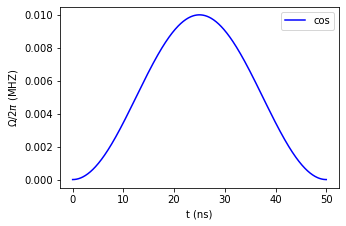

In [4]:
tlist = np.linspace(0,50,501)
angle = np.pi
T = 50
p_max = angle/(0.5*T)
def f_cos(t,T_cos,p_max):
    return 0.5*p_max*(1+np.cos((t-T_cos/2)*(2*np.pi/T_cos)))

P_cos = 0.5*f_cos(tlist,T,p_max)

fig, ax = plt.subplots(figsize=(5,5*2/3))
ax.plot(tlist, P_cos/(2*np.pi), 'b', label="cos")
ax.set_xlabel('t (ns)')
ax.set_ylabel('$\Omega/2\pi$ (MHZ)')
ax.legend()
plt.show()

1858.1905567189369
2.1420563502653365
77.530161588077476
28.820817977851561
6.1235003368373029
0.4867330089106825
0.51942530544620813
0.61019485352553238
0.49763576432229129
0.40283216248693055
0.35048378887433879
0.32071370117185427
0.29918991085930158
0.28024703780608268
0.26184566768544459
0.24345524853451314
0.2249468291983055
0.20641966921312122
0.18800810659268807
0.16989663675933916
0.15226861308292353
0.13530641452470868
0.11917752559781072
0.10402540133309342
0.089966572138552026
0.077084517569986022
0.065428948249391786
0.055015509776939281
break at iteration 500 with cost 0.04935808543100153
Gate Unitary:  tf.Tensor(
[[2.71808790e-01+2.06246462e-14j 5.82527426e-15+9.62351278e-01j]
 [5.82527426e-15+9.62351278e-01j 2.71808790e-01+2.06246462e-14j]], shape=(2, 2), dtype=complex128)


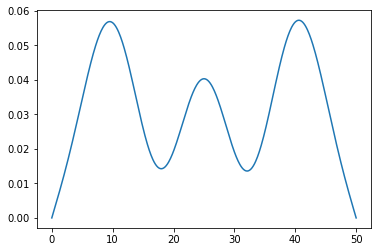

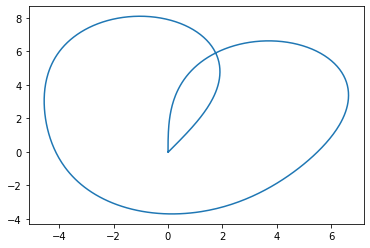

In [6]:
itr = 2000
Nc = 3
L_rate = 0.06

angle = np.pi
U_target = (-1j*1/2 * angle * sigmax()).expm()

Px_i = P_cos

P1, C_list, F_list, curve = optimize_pulse_test(Px_i, tlist, itr, Nc, L_rate, U_target)

plt.figure()
plt.plot(tlist,P1/(2*np.pi))
plt.figure()
plt.plot(curve[1],curve[2])